In [1]:
from pathlib import Path
from fastai.vision.all import *

In [8]:
ResizeMethod

fastcore.basics.ResizeMethod

In [4]:
dls = ImageDataLoaders.from_folder(
    Path('../data/processed'), 
    train='train', 
    valid_pct=0.2,
    size=224,
    bs=4,
    shuffle_train=True,
    item_tfms=Resize(256, method=ResizeMethod.Squish)
)

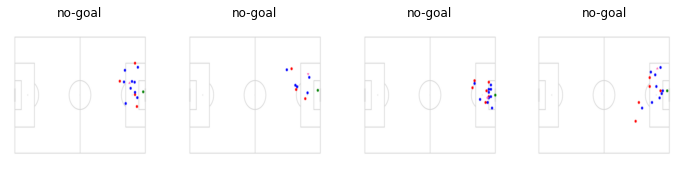

In [7]:
dls.show_batch(nrows=1, ncols=4)

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)